# AP156 Manuscript - Multipole Expansion

Domingo, Kenneth V.<br />
2015-03116

In [5]:
import numpy as np
import numpy.random as rd
import matplotlib as mpl
import matplotlib.pyplot as mp
from mpl_toolkits.mplot3d import Axes3D

#mp.rcParams["text.usetex"] = True
#mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (7,7)
mp.rcParams["figure.dpi"] = 72

In [10]:
class MultipoleExpansion(object):
    """
    Multipole Expansion, in W. Kinzel and G. Reents, "Physics by Computer: Programming
    Physical Problems using Mathematica and C", pp. 30-36.
    
    This code calculates the electrostatic potential and field of an arbitrary
    even-numbered, discrete charge distribution.
    
    Parameters
    ----------
    N : int
        Number of unit charges in the distribution
        
    Returns
    -------
    `MultipoleExpansion` object
        An object on which the various functions defined under the MultipoleExpansion
        class can be applied
    
    __author__ = "Kenneth V. Domingo"
    __credits__ = "W. Kinzel, G. Reents"
    
    References
    ----------
    [1] Kinzel, W., and Reents, G. (1998). Multipole expansion. In M. Clajus, and 
        B. Freeland-Clajus (Trans.), Physics by computer: programming physical problems
        using Mathematica and C (pp. 30-36). New York: Springer (Original work published 1996).
    [2] Wilmott, P., Howison, S., and Dewynne, J. (1995). The mathematics of financial derivatives:
        a student introduction (p. 137). Cambridge University Press.
    [3] Olver, P. (2013). Introduction to partial differential equations (p. 182). Springer Science
        & Business Media.
    [4] Hunter, J.D. (2007). Matplotlib: a 2D graphics environment. Computing in science and
        engineering 9(3), 90-95.
    [5] Gradshteyn, I.S., Ryzhik, I.M. (1994). Table of integrals, series, and products.
        Boston, MA: Academic Press.
    [6] Jackson, J.D. (1975). Classical electrodynamics. New York: Wiley.
    [7] Griffiths, D.J. (1999). Introduction to electrodynamics (3rd ed.). New Jersey: Prentice-Hall.
    [8] christian. (2015, 10 December). Visualizing a vector field with Matplotlib. Retrieved 12
        October 2018, from Learning scientific programming with Python:
        https://scipython.com/blog/visualizing-a-vector-field-with-matplotlib/.
    """
    
    
    def __init__(self, N):
        if N%2 != 0:
            raise ValueError("N must be even")
        
        rd.seed(314159)
        self.N = int(N)
        
        def rpoint():
            return np.array([2*rd.random()-1, 2*rd.random()-1, 0], float)
        
        self.r = np.array([rpoint() for i in range(self.N)], float)
        self.dipole = sum([self.r[i] - self.r[i+self.N//2] for i in range(self.N//2)])
        self.x = np.linspace(-2,2,500)
        self.y = np.linspace(-2,2,500)
        self.X,self.Y = np.meshgrid(self.x,self.y)
    
    
    def dist(self,p1,p2):
        """
        Calculates the Euclidean distance between two arbitrary objects (can be points or arrays)
        
        Parameters
        ----------
        p1, p2 : array_like
            Two objects (points or arrays) whose distances to be determined
        """
        return np.sqrt(np.dot((p1-p2),(p1-p2)))

    
    def pot(self,rh):
        """
        Calculates exact potential at a point in space relative to the charge distribution
        
        Parameters
        ----------
        rh : array_like
            Position vector which defines the point at which the potential must be calculated
            
        Returns
        -------
        phi : array_like
            Potential at point rh
        """
        r = self.r
        return sum([1/self.dist(rh,r[i]) - 1/self.dist(rh,r[i+self.N//2]) for i in range(self.N//2)])

    
    def quadrupole(self,r):
        """
        Evaluates the quadrupole tensor at a point r
        
        Parameters
        ----------
        r : array_like
            Position vector which defines the point at which the potential must be calculated
            
        Returns
        -------
        Q : array_like
            Quadrupole tensor evaluated at point r
        """
        Q = np.zeros((3,3),float)
        for k in range(3):
            for l in range(3):
                if k == l:
                    dk = np.dot(r,r)
                else:
                    dk = 0
                Q[k,l] = 3*r[k]*r[l] - dk
        return Q

    
    def qsum(self):
        """
        Calculates the quadrupole moment
        
        Parameters
        ----------
        r : array_like
            Position vector which defines the point at which the quadrupole moment
            
        Returns
        -------
        phi : array_like
            Quadrupole moment felt at point r
        """
        r = self.r
        return sum([self.quadrupole(r[i]) - self.quadrupole(r[i+self.N//2]) for i in range(self.N//2)])

    
    def magn(self,r):
        """
        Extracts the magnitude of an array
        
        Parameters
        ----------
        r : array_like
            Array whose magnitude is to be taken
        
        Returns
        -------
        |r| : float
            Magnitude of r
        """
        suma = 0.0
        for i in range(len(r.flat[:])):
            suma += r.flat[i]**2
        return np.sqrt(suma)

    
    def pot1(self,r):
        """
        Calculates the potential at a point using dipole approximation
        
        Parameters
        ----------
        r : array_like
            Position vector which defines the point at which the potential must be calculated
            
        Returns
        -------
        phi : array_like
            Dipole-approximated potential at point r
        """
        return np.dot(self.dipole,r)/self.magn(r)**3

    
    def pot2(self,r):
        """
        Calculates the potential at a point using quadrupole approximation
        
        Parameters
        ----------
        r : array_like
            Position vector which defines the point at which the potential must be calculated
            
        Returns
        -------
        phi : array_like
            Quadrupole-approximated potential at point r
        """
        return self.pot1(r) + 1/2/self.magn(r)**5 * np.dot(np.dot(r,self.qsum()),r)

    
    def diff_central(self,r,slices):
        """
        Central difference algorithm for numerically calculating a first-order derivative
        
        Parameters
        ----------
        r : array_like
            Vector containing x,y,z components of the point to be evaluated
        
        Returns
        -------
        E : array_like
            Vector containing x,y,z components of the derivative at point r
        """
        x,y,z = r
        h = 4/slices
        Ex = (self.pot([x + h/2, y, z]) - self.pot([x - h/2, y, z]))/h
        Ey = (self.pot([x, y + h/2, z]) - self.pot([x, y - h/2, z]))/h
        Ez = (self.pot([x, y, z + h/2]) - self.pot([x, y, z - h/2]))/h
        return np.array([Ex,Ey,Ez], float)

    
    def direction(self,f):
        return f/self.magn(f)
    
    
    def location_2D(self, save=False):
        """
        Plots the distribution of charges on the x-y plane
        
        Parameters
        ----------
        save : boolean
            Indicates whether plot should be saved
            
        Returns
        -------
        `matplotlib.AxesPlot` object
        """
        r = self.r
        N = self.N
        fig = mp.figure()
        ax = fig.add_subplot(111)
        ax.grid(False)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.plot(r[:N//2,0], r[:N//2,1], color="r", marker=r"$\oplus$", ms=12, mew=1, ls="")
        ax.plot(r[N//2:,0], r[N//2:,1], color="b", marker=r"$\ominus$", ms=12, mew=1, ls="")
        if save:
            mp.savefig("113.png", dpi=300, bbox_inches="tight")
        ax.set_title("(1.13) Random distribution of %i charges in the $x$-$y$ plane"%self.N)
        mp.show()
        
        
    def location_3D(self, save=False):
        """
        Plots the distribution of charges in space
        
        Parameters
        ----------
        save : boolean
            Indicates whether plot should be saved
            
        Returns
        -------
        `matplotlib.AxesPlot` object
        """
        r = self.r
        N = self.N
        fig = mp.figure()
        ax = fig.add_subplot(111, projection="3d")
        #ax.view_init(90,-90)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$z$")
        ax.plot(r[:N//2,0], r[:N//2,1], r[:N//2,2], color="r", marker=r"$\oplus$", ms=12, mew=1, ls="")
        ax.plot(r[N//2:,0], r[N//2:,1], r[N//2:,2], color="b", marker=r"$\ominus$", ms=12, mew=1, ls="")
        if save:
            mp.savefig("113-1.png", dpi=300, bbox_inches="tight")
        mp.show()
        
    def surface(self, save=False):
        """
        Surface plot of the potential arising from the charges
        
        Parameters
        ----------
        save : boolean
            Indicates whether plot should be saved
            
        Returns
        -------
        `matplotlib.AxesPlot` object
        """
        Z = self.pot([self.X,self.Y,0.1])
        fig = mp.figure(figsize=(16,12))
        ax = fig.add_subplot(111, projection="3d")
        ax.view_init(27, -21)
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$\Phi$")
        ax.plot_surface(self.X,self.Y,Z, cmap="coolwarm", rstride=3, cstride=3, lw=1, antialiased=True)
        if save:
            mp.savefig("114.png", dpi=300, bbox_inches="tight")
        ax.set_title("(1.14) Potential of %i unit charges in the plane $z=0.1$"%self.N)
        mp.show()
        
        
    def contour(self, save=False):
        """
        Contour plot of the potential arising from the charges
        
        Parameters
        ----------
        save : boolean
            Indicates whether plot should be saved
            
        Returns
        -------
        `matplotlib.AxesPlot` object
        """
        r = self.r
        N = self.N
        Z = self.pot([self.X,self.Y,0.1])
        mp.figure()
        mp.grid(False)
        mp.xlabel("$x$")
        mp.ylabel("$y$")
        mp.plot(r[:N//2,0], r[:N//2,1], color="r", marker="$\oplus$", ms=12, mew=1, ls="")
        mp.plot(r[N//2:,0], r[N//2:,1], color="b", marker="$\ominus$", ms=12, mew=1, ls="")
        mp.contourf(self.X,self.Y,Z, 10, cmap="coolwarm")
        mp.colorbar(aspect=30)
        if save:
            mp.savefig("115.png", dpi=300, bbox_inches="tight")
        mp.title("(1.15) Potential of %i unit charges on the plane $z=0.1$"%self.N)
        mp.show()
        
        
    def compare(self, save=False):
        """
        Compares the exact potential with the dipole and quadrupole approximations along a plane
        
        Parameters
        ----------
        save : boolean
            Indicates whether plot should be saved
            
        Returns
        -------
        `matplotlib.AxesPlot` object
        """
        mp.figure(figsize=(7*16/9,7))
        mp.xlabel("$y$")
        mp.ylabel("$\Phi$")
        z_exact = np.zeros_like(self.y)
        z_dip = np.zeros_like(self.y)
        z_quad = np.zeros_like(self.y)
        for i in range(len(self.y)):
            z_exact[i] = self.pot([0.1,self.y[i],0.1])
            z_dip[i] = self.pot1(np.array([0.6,self.y[i],0.1]))
            z_quad[i] = self.pot2(np.array([0.6,self.y[i],0.1]))
        mp.plot(self.y, z_exact, "b-", label="exact potential")
        mp.plot(self.y, z_dip, "r:", label="dipole approximation")
        mp.plot(self.y, z_quad, "g--", label="quadrupole approximation")
        mp.legend()
        if save:
            mp.savefig("116.png", dpi=300, bbox_inches="tight")
        mp.title("(1.16) Potentials for different approximations")
        mp.show()
        
        
    def field(self, d, save=False):
        """
        Streamplot of the electric field associated with the potential arising from the charges
        
        Parameters
        ----------
        d : array-like
            Distance from which the charge distribution is viewed
        save : boolean
            Indicates whether plot should be saved
            
        Returns
        -------
        `matplotlib.AxesPlot` object
        """
        r,N = self.r, self.N
        fig = mp.figure()
        ax = fig.add_subplot(111)
        ax.grid(False)
        x,y = np.linspace(-d,d,1000), np.linspace(-d,d,1000)
        X,Y = np.meshgrid(x,y)
        Ex,Ey,Ez = self.diff_central([X,Y,0.1], 1000)
        color = np.log(np.hypot(Ex,Ey))
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.streamplot(x, y, Ex, Ey, density=1.5, color=color, cmap="magma", arrowstyle="->", arrowsize=1.5)
        if d <= 2.5:
            ax.set_xlim(-d,d)
            ax.plot(r[:N//2,0], r[:N//2,1], color="r", marker="$\oplus$", ms=12, mew=1, ls="")
            ax.plot(r[N//2:,0], r[N//2:,1], color="b", marker="$\ominus$", ms=12, mew=1, ls="")
        if save:
            fname = "117-" + str(d) + ".png"
            mp.savefig(fname, dpi=300, bbox_inches="tight")
        ax.set_title("Electric field of the charge distribution viewed from %i m away"%d)
        mp.show()
        
        
    def run_all(self, d, save=False):
        """
        Calculates and displays all the plots
        
        Parameters
        ----------
        d : array-like
            Distance from which the charge distribution is viewed
        save : boolean
            Indicates whether all plots should be saved
            
        Returns
        -------
        `matplotlib.AxesPlot` object
        """
        self.location_2D(save)
        self.location_3D(save)
        self.surface(save)
        self.contour(save)
        self.compare(save)
        if not (type(d) == float or type(d) == int):
            for i in d:
                self.field(i,save)
        else:
            self.field(d,save)

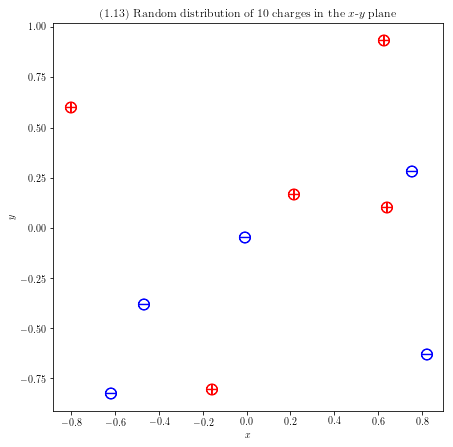

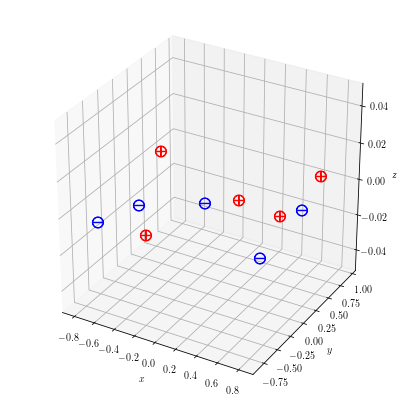

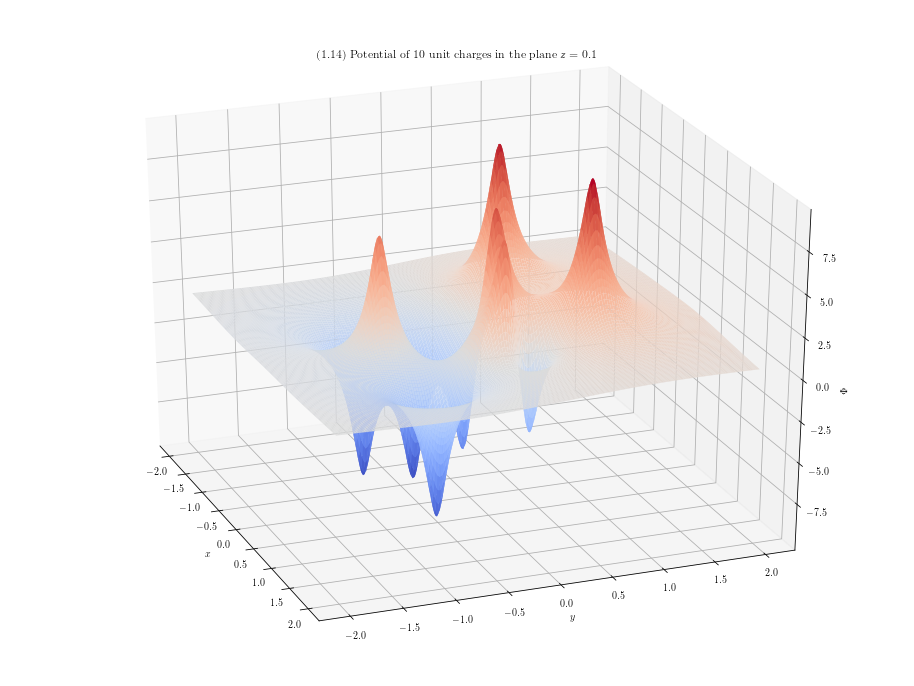

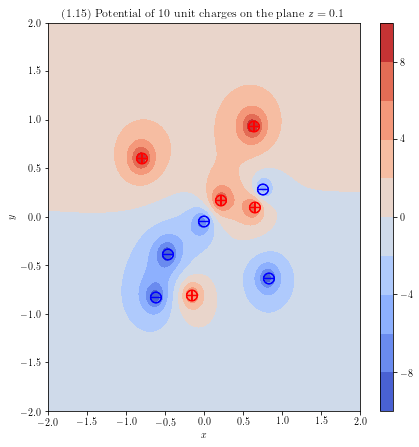

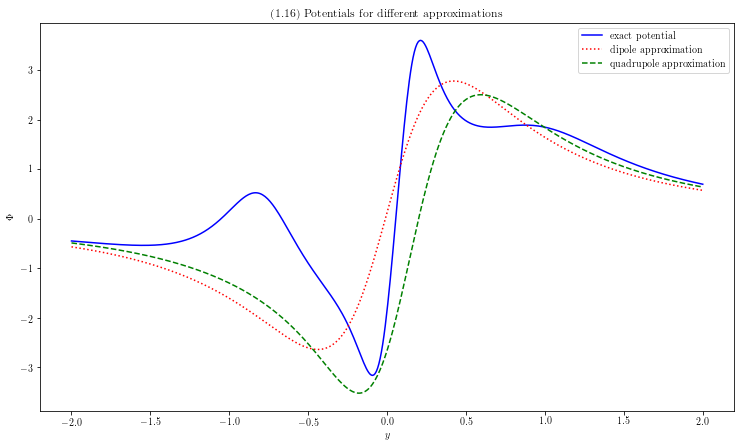

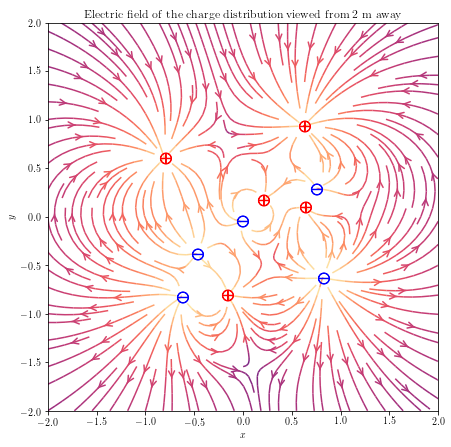

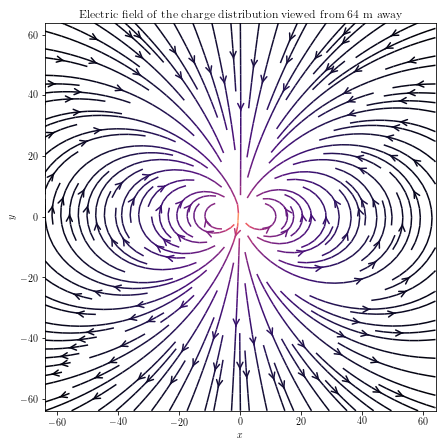

In [11]:
sim = MultipoleExpansion(10)
sim.run_all(d=[2,64])